In [0]:
import pandas as pd

data = pd.read_csv('TXF_1min.csv').drop(columns = 'Unnamed: 0')
details = pd.read_csv('detail.csv')

data.Time = pd.to_datetime(data.Time)
data = data.set_index('Time')

In [0]:
def convert(df, interval, unit):
    period = '{i}{u}'.format(i = interval, u = unit)
    df = df.resample(period).agg({'Open':'first', 'High':'max', 'Low':'min','Close':'last','Volume':'sum'}).dropna(axis=0)
    df.reindex(pd.to_datetime(df.index.strftime('%F %T')))
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    return df

In [0]:
!pip install mpl_finance

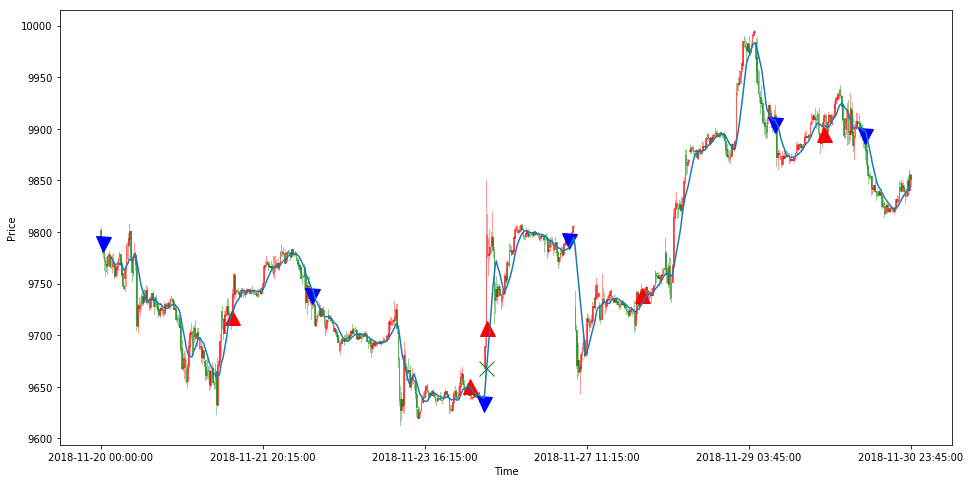

In [34]:
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ochl
from matplotlib import gridspec

min_15 = convert(df = data, interval = 15, unit = 'MIN')
plot_data = min_15['2018-11-20':'2018-11-30']
plot_data = plot_data.reset_index()


def Plot_Candlestick(data, info, title = ''):
    data.columns = data.columns.str.upper()
    if all(name in data.columns.tolist() for name in ['TIME', 'OPEN', 'HIGH', 'LOW', 'CLOSE']):
        fig = plt.figure(figsize = (16, 8))
        x_interval = int(len(data)/5)
        gs = gridspec.GridSpec(3,1)
        # self.k_ax = self.fig.add_subplot(gs[0:2])
        k_ax = fig.add_subplot(gs[0:3])
        k_ax.set_xticks(range(0, len(data['TIME']), x_interval))
        k_ax.set_xticklabels(data['TIME'][::x_interval])
        k_ax.ticklabel_format(useOffset=False, style='plain', axis='y')
        plt.title(title)
        plt.ylabel('Price')
        plt.xlabel('Time')
        candlestick2_ochl(k_ax,
                          data['OPEN'].values,
                          data['CLOSE'].values,
                          data['HIGH'].values,
                          data['LOW'].values,
                          width = 0.6,
                          colorup = 'r',
                          colordown = 'green',
                          alpha = 0.4)
        data['MA10'] = data['CLOSE'].rolling(center = False, window = 10).mean()
        Add_Point(info['idx_buy'], info['price_buy'], 'long')
        Add_Point(info['idx_sell'], info['price_sell'], 'short')
        Add_Point(info['idx_stoploss'], info['price_stoploss'], 'stoploss')
        plt.plot(data.MA10)
    else:
        print('Column(Date, OPEN, HIGH, LOW or CLOSE) is missing!')

        
def Add_Point(date, price, flag = 'long'):
    for i in range(len(date)):
        if flag == 'long':
            color = 'red'
            marker = '^'
        elif flag == 'short':
            color = 'blue'
            marker = 'v'
        elif flag == 'stoploss':
            color = 'green'
            marker = 'x'
            
        plt.plot(date[i], price[i], marker = marker, markersize = 15, color = color)


def Change_Period(t, interval, unit):
    period = '{i}{u}'.format(i = interval, u = unit)
    
    _time = pd.to_datetime(t)
    df = pd.DataFrame({'Time':_time, 'Price':[0]}).set_index('Time')
    output_time = df.resample(period, closed = 'right', label = 'right').agg({'Price':'first'}).index[0]
    
    return output_time



def Get_Signal_index(data, details):
    idx_buy = []
    price_buy = []
    idx_sell = []
    price_sell = []
    idx_close = []
    price_close = []

    for idx, detail in details.iterrows():
        open_time = Change_Period(t = detail.open_time, interval = 15, unit = 'Min')
        close_time = Change_Period(t = detail.close_time, interval = 15, unit = 'Min')
        open_idx = data[data['Time'] == open_time]
        close_idx = data[data['Time'] == close_time]
        
        if not open_idx.empty:
            if detail.side == 'buy':
                idx_buy.append(open_idx.index.tolist()[0])
                price_buy.append(detail.open_price)
            elif detail.side == 'sell':
                idx_sell.append(open_idx.index.tolist()[0])
                price_sell.append(detail.open_price)
                
        if not close_idx.empty:
            idx_close.append(close_idx.index.tolist()[0])
            price_close.append(detail.close_price)
            
    return idx_buy, price_buy, idx_sell, price_sell, idx_close, price_close



def Select_Stoploss(idx_b, price_b, idx_s, price_s, idx_c, price_c):
    idx_stoploss = []
    price_stoploss = []
    
    for i, v in enumerate(idx_c):
        if v not in idx_b + idx_s:
            idx_stoploss.append(v)
            price_stoploss.append(price_c[i])
            
    return idx_stoploss, price_stoploss


idx_b, price_b, idx_s, price_s, idx_c, price_c = Get_Signal_index(plot_data, details)
idx_sl, price_sl = Select_Stoploss(idx_b, price_b, idx_s, price_s, idx_c, price_c)
            
info = {}
info['idx_buy'] = idx_b
info['price_buy'] = price_b
info['idx_sell'] = idx_s
info['price_sell'] = price_s
info['idx_stoploss'] = idx_sl
info['price_stoploss'] = price_sl


Plot_Candlestick(plot_data, info)

plt.show()


In [0]:

def Select_Stoploss(idx_b, price_b, idx_s, price_s, idx_c, price_c):
    idx_stoploss = []
    price_stoploss = []
    
    for i, v in enumerate(idx_c):
        if not v in (idx_b, idx_s):
            idx_stoploss.append(v)
            price_stoploss.append(price_c[i])
            
    return idx_stoploss, price_stoploss


idx_sl, price_sl = Select_Stoploss(idx_b, price_b, idx_s, price_s, idx_c, price_c)

print(idx_sl)
print(price_sl)